In [67]:
from qiskit import QuantumCircuit, transpile
from qiskit.synthesis import synth_cnot_count_full_pmh
from ai_linear_function_synthesis import *
from qiskit.quantum_info import Operator
from qiskit.circuit.library import LinearFunction

from tqdm import tqdm
from stable_baselines3 import PPO


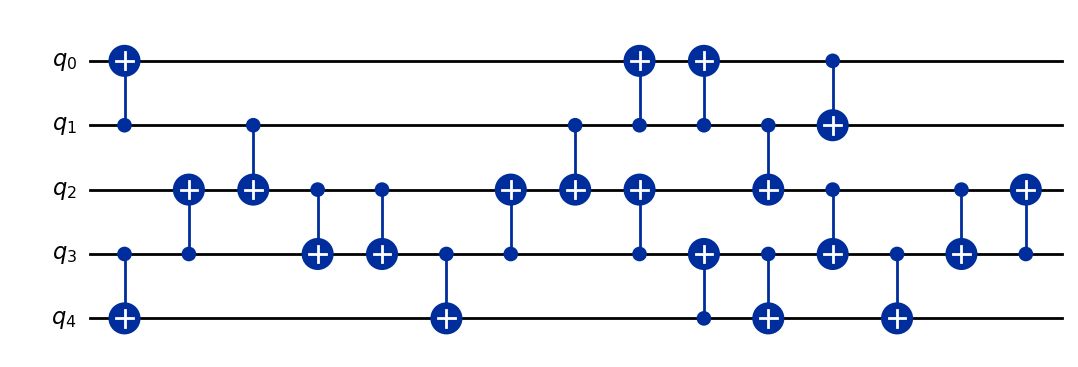

In [68]:
NUM_QUBITS = 5
COUPLING_MAP = CouplingMap.from_line(NUM_QUBITS)
BATCH_SIZE = 100
SUCCESS_RATE_THRESHOLD = 0.8

np.random.seed(0)

# get random circuit
qc = random_linear_function_circuit_by_difficulty(
    NUM_QUBITS,
    difficulty=20,
    coupling_map=COUPLING_MAP,
)
qc.draw("mpl")

In [69]:
binary_matrix = linear_function_circuit_to_binary_matrix(qc)
binary_matrix

array([[ True,  True, False, False, False],
       [ True, False, False, False, False],
       [False,  True,  True, False,  True],
       [False, False, False,  True,  True],
       [False,  True,  True,  True,  True]])

In [70]:
LinearFunction._circuit_to_mat(qc)

array([[ True,  True, False, False, False],
       [ True, False, False, False, False],
       [False,  True,  True, False,  True],
       [False, False, False,  True,  True],
       [False,  True,  True,  True,  True]])

CNOT count by PMH synthesis: 7


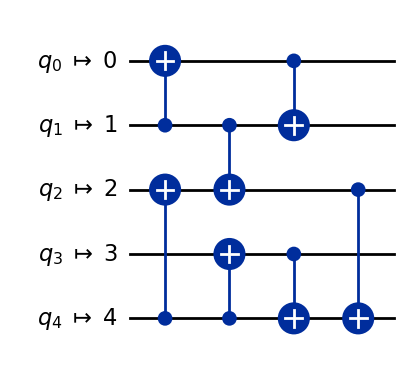

In [78]:
qc_qiskit = synth_cnot_count_full_pmh(binary_matrix)
qc_qiskit = transpile(
    qc_qiskit,
    # coupling_map=COUPLING_MAP,
    optimization_level=3,
    # basis_gates=["cx", "u3"],
    initial_layout=list(range(NUM_QUBITS)),
)
print(f"CNOT count by PMH synthesis: {qc_qiskit.count_ops().get('cx', 0)}")
qc_qiskit.draw("mpl")

In [79]:
linear_function_circuit_to_binary_matrix(qc_qiskit)

array([[ True,  True, False, False, False],
       [ True, False, False, False, False],
       [False,  True,  True, False,  True],
       [False, False, False,  True,  True],
       [False,  True,  True,  True,  True]])

In [6]:
model = PPO.load("saved_models/lin_func_curriculum", print_system_info=True)
env = AILinearFunctionSynthesis(
    coupling_map=COUPLING_MAP,
    eval_batch_size=BATCH_SIZE,
    success_rate_threshold=SUCCESS_RATE_THRESHOLD,
)

== CURRENT SYSTEM INFO ==
- OS: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.35 # 1 SMP PREEMPT_DYNAMIC Thu Jun  5 18:30:46 UTC 2025
- Python: 3.12.10
- Stable-Baselines3: 2.7.0
- PyTorch: 2.9.0+cu128
- GPU Enabled: True
- Numpy: 2.2.6
- Cloudpickle: 3.1.1
- Gymnasium: 1.2.1

== SAVED MODEL SYSTEM INFO ==
- OS: Linux-6.6.87.2-microsoft-standard-WSL2-x86_64-with-glibc2.39 # 1 SMP PREEMPT_DYNAMIC Thu Jun  5 18:30:46 UTC 2025
- Python: 3.12.11
- Stable-Baselines3: 2.7.0
- PyTorch: 2.9.0+cu128
- GPU Enabled: True
- Numpy: 2.2.6
- Cloudpickle: 3.1.1
- Gymnasium: 1.2.1



========== step 0 ==========
QuantumCircuit:
     
q_0: 
     
q_1: 
     
q_2: 
     
q_3: 
     
q_4: 
     
state:
[[[ True  True False False False]
  [ True False False False False]
  [False  True  True False  True]
  [False False False  True  True]
  [False  True  True  True  True]]]
num_cnots: 0
truncated: False
terminated: False
========== step 1 ==========
action: 0, reward: -0.01, info: {'is_success': False}
QuantumCircuit:
          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘
q_2: ─────
          
q_3: ─────
          
q_4: ─────
          
state:
[[[ True  True False False False]
  [False  True False False False]
  [False  True  True False  True]
  [False False False  True  True]
  [False  True  True  True  True]]]
num_cnots: 1
truncated: False
terminated: False
========== step 2 ==========
action: 5, reward: -0.01, info: {'is_success': False}
QuantumCircuit:
          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └─┬─┘
q_3: ──■──
          
q_4: ─────
      

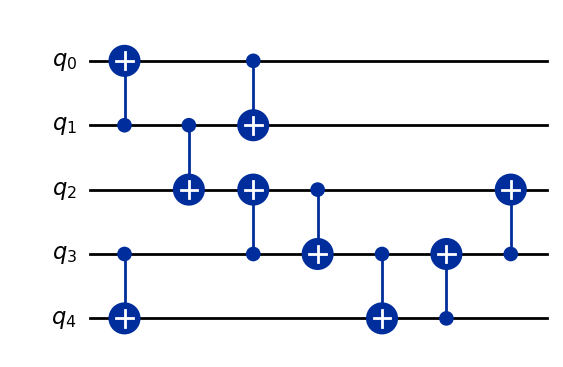

In [7]:
env.reset()
env.state = binary_matrix[np.newaxis, :, :].copy()
env.difficulty = None
step_count = 0

print(f"========== step {step_count} ==========")
env.render()

# after setting env.state manually, get the observation
obs = env._get_obs()

episode_over = False
while not episode_over:
    # Use the trained agent's policy (PPO) to select actions
    action, _states = model.predict(obs, deterministic=True)

    obs, reward, terminated, truncated, info = env.step(int(action))
    step_count += 1

    print("truncated:", truncated)
    print("terminated:", terminated)
    episode_over = terminated or truncated

    print(f"========== step {step_count} ==========")
    print(f"action: {action}, reward: {reward}, info: {info}")
    qc_rl = env.render()

print(f"Episode finished. Total reward: {reward}, steps: {step_count}, success: {info.get('is_success', False)}")
qc_rl.inverse().draw("mpl")

In [8]:
# you need to invert the circuit to recover the original circuit
linear_function_circuit_to_binary_matrix(qc_rl.inverse())

array([[ True,  True, False, False, False],
       [ True, False, False, False, False],
       [False,  True,  True, False,  True],
       [False, False, False,  True,  True],
       [False,  True,  True,  True,  True]])

# 100 circuits model test

In [9]:
NUM_QUBITS = 5
COUPLING_MAP = CouplingMap.from_line(NUM_QUBITS)
BATCH_SIZE = 100
SUCCESS_RATE_THRESHOLD = 0.8

NUM_CIRCUITS = 100
qiskit_circuit_cnot_counts = []
qiskit_circuit_depths = []
rl_circuit_cnot_counts = []
rl_circuit_depths = []


for i in tqdm(range(NUM_CIRCUITS)):
    np.random.seed(i)

    # get random circuit
    qc = random_linear_function_circuit_by_difficulty(
        NUM_QUBITS,
        difficulty=20,
        coupling_map=COUPLING_MAP,
    )
    binary_matrix = linear_function_circuit_to_binary_matrix(qc)

    qc_qiskit = synth_cnot_count_full_pmh(binary_matrix)
    qc_qiskit = transpile(
        qc_qiskit,
        coupling_map=COUPLING_MAP,
        optimization_level=3,
        basis_gates=["cx", "u3"],
        initial_layout=list(range(NUM_QUBITS)),
    )

    np.testing.assert_allclose(Operator(qc_qiskit), Operator(qc))

    qiskit_circuit_cnot_counts.append(qc_qiskit.count_ops().get("cx", 0))
    qiskit_circuit_depths.append(qc_qiskit.depth())

    model = PPO.load("saved_models/lin_func_curriculum", print_system_info=True)
    env = AILinearFunctionSynthesis(
        coupling_map=COUPLING_MAP,
        eval_batch_size=BATCH_SIZE,
        success_rate_threshold=SUCCESS_RATE_THRESHOLD,
    )

    env.reset()
    env.state = binary_matrix[np.newaxis, :, :].copy()
    env.difficulty = None
    step_count = 0

    # after setting env.state manually, get the observation
    obs = env._get_obs()

    episode_over = False
    while not episode_over:
        # Use the trained agent's policy (PPO) to select actions
        action, _states = model.predict(obs, deterministic=True)

        obs, reward, terminated, truncated, info = env.step(int(action))
        step_count += 1

        episode_over = terminated or truncated

    np.testing.assert_allclose(Operator(qc_qiskit), Operator(qc_rl))

    rl_circuit_cnot_counts.append(qc_rl.count_ops().get("cx", 0))
    rl_circuit_depths.append(qc_rl.depth())

  0%|          | 0/100 [00:00<?, ?it/s]


AssertionError: 
Not equal to tolerance rtol=1e-07, atol=0

Mismatched elements: 32 / 1024 (3.12%)
Max absolute difference among violations: 1.
Max relative difference among violations: 1.
 ACTUAL: array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],...
 DESIRED: array([[1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],...